## Book Recommendation using LLMs
### Part 1: Data Exploration

Read Data from Kagglehub

In [ ]:
# Library imports
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")
print("Path to dataset files:", path)

# Read data
books = pd.read_csv(f"{path}/books.csv")

Path to dataset files: /kaggle/input/7k-books-with-metadata


View data as a DataFrame

In [ ]:
# Explore dataset
print(books.head())
print(books.columns)

          isbn13      isbn10           title subtitle  \
0  9780002005883  0002005883          Gilead      NaN   
1  9780002261982  0002261987    Spider's Web  A Novel   
2  9780006163831  0006163831    The One Tree      NaN   
3  9780006178736  0006178731  Rage of angels      NaN   
4  9780006280897  0006280897  The Four Loves      NaN   

                           authors                     categories  \
0               Marilynne Robinson                        Fiction   
1  Charles Osborne;Agatha Christie  Detective and mystery stories   
2             Stephen R. Donaldson               American fiction   
3                   Sidney Sheldon                        Fiction   
4              Clive Staples Lewis                 Christian life   

                                           thumbnail  \
0  http://books.google.com/books/content?id=KQZCP...   
1  http://books.google.com/books/content?id=gA5GP...   
2  http://books.google.com/books/content?id=OmQaw...   
3  http://books.go

### Data Inspection

In [ ]:
import numpy as np
# Inspect unique values and missing data
print(f"Number of books: {books.shape[0]}")
print(f"Number of NaN entries in subtitle: {books['subtitle'].isna().sum()}")
print(f"Number of unique book categories: {len(books['categories'].unique())}")
print(f"Number of NaN entries in description: {books['description'].isna().sum()}")

Number of books: 6810
Number of NaN entries in subtitle: 4429
Number of unique book categories: 568
Number of NaN entries in description: 262


Comments on the above statistics

1.   Too many NaN values in the *description* column **->** This column must be discarded or some special treatment must be done to make it useful.
2.   Too many different book categories **->** Reduce this number to make it useful.
3. Description could be a useful column for the purpose of recommendation. Not too many NaN values detected in the dataset.
4. To test **->** Does the missing values or NaNs have a particulr distribution or a pattern?



Visualize data

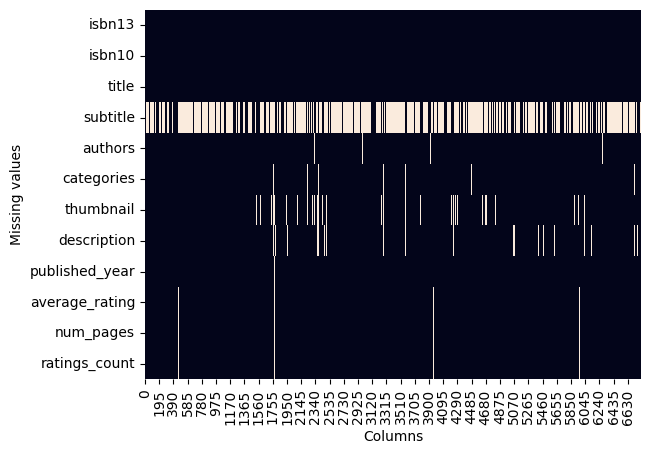

In [ ]:
# Library imports
import seaborn as sns
import matplotlib.pyplot as plt

# Data visualization: Heat map of missing values
ax = plt.axes()
sns.heatmap(books.isna().transpose(), cbar=False, ax=ax)
plt.xlabel("Columns")
plt.ylabel("Missing values")
plt.show()

Look for patterns: Is the description missing for say older books, or shorter books, and so on.

In [ ]:
# Numerical representation
books['missing_description'] = np.where(books['description'].isna(), 1, 0)
books['age_of_book'] = 2025 - books['published_year']

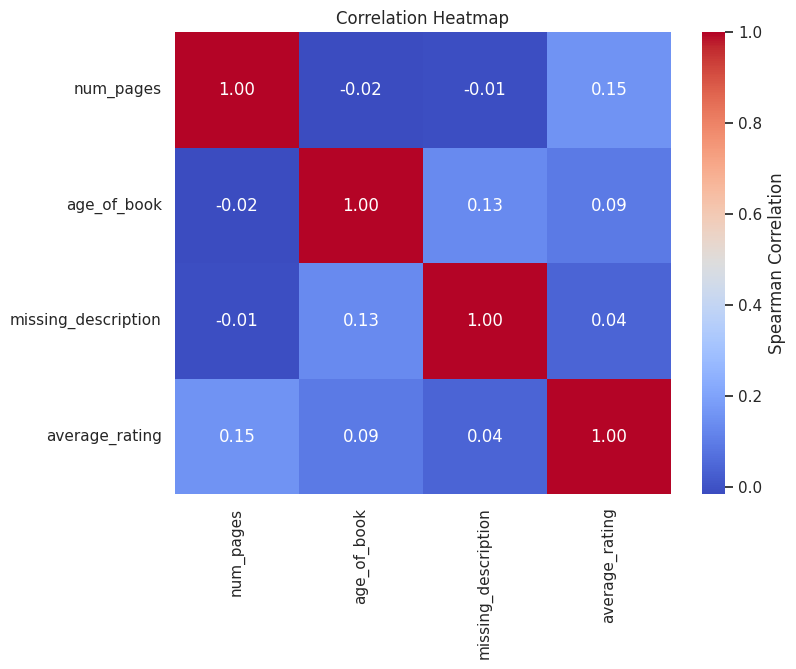

In [ ]:
# Form columns of interest to look for patterns in missing data
columns_of_interest = ['num_pages', 'age_of_book', 'missing_description', 'average_rating']
correlation_matrix = books[columns_of_interest].corr(method='spearman')

# Plot correlation matrix
sns.set_theme(style='white')
plt.figure(figsize=[8,6])
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"label": "Spearman Correlation"})
heatmap.set_title("Correlation Heatmap")
plt.show()

Strong correlation is not observed for missing description.

In [ ]:
# Count how many book entries have missing values for columns of interest
books_missing = books[books['description'].isna() |
                      books['num_pages'].isna() |
                      books['average_rating'].isna() |
                      books['published_year'].isna()]
print(f"Number of books with at least one column of interest values missing: {books_missing.shape[0]}")

Number of books with at least one column of interest values missing: 303


### Data Clean-up

In [ ]:
# Dataframe after removing missing values
books = books[~(books['description'].isna()) &
              ~(books['num_pages'].isna()) &
              ~(books['average_rating'].isna()) &
              ~(books['published_year'].isna())]

print(f"Cleaned dataframe size: {books.shape}")

Cleaned dataframe size: (6507, 14)


Handle the large number of book categories

In [ ]:
# Check the number of book categories after data clean-up and visualize it
print(f"Number of book categories after data clean-up: {len(books['categories'].unique())}")
# Value counts of categories
books['categories'].value_counts().reset_index().sort_values("count", ascending=False)


Number of book categories after data clean-up: 532


,categories,count
0,Fiction,2523
1,Juvenile Fiction,534
2,Biography & Autobiography,391
3,History,258
4,Literary Criticism,164
...,...,...
519,"Adventure stories, English",1
518,Germany,1
517,Egypt,1
516,Apartments,1


Analyze the length of description of books

<ipython-input-10-9d2dfc4767de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['words_in_description'] = books['description'].str.split().str.len()


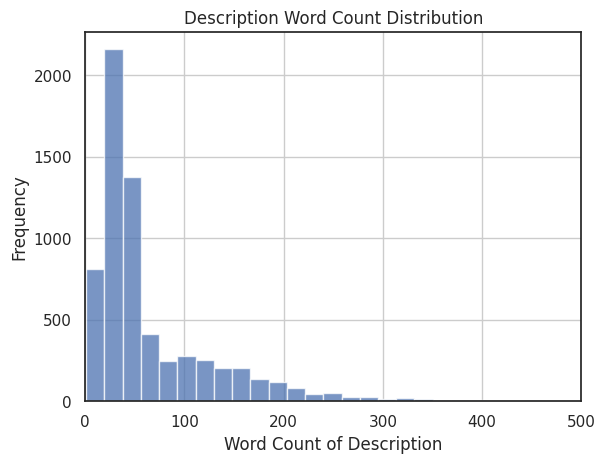

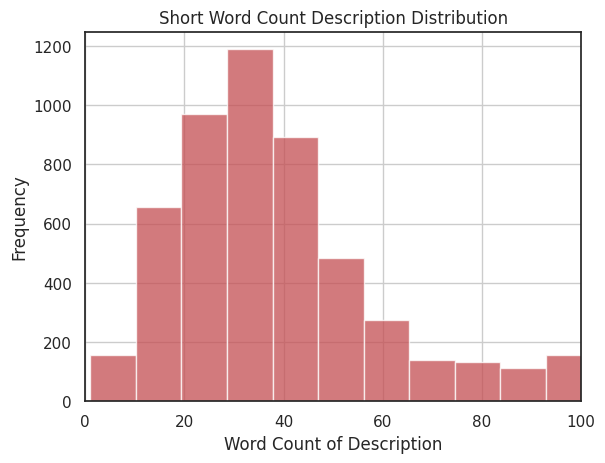

In [ ]:
books['words_in_description'] = books['description'].str.split().str.len()
# Histogram
books['words_in_description'].hist(bins=50, alpha=0.75)
plt.title('Description Word Count Distribution')
plt.xlim(0,500)
plt.xlabel('Word Count of Description')
plt.ylabel('Frequency')
plt.show()
# Histogram - Short desciption
books['words_in_description'].hist(bins=100, color='r', alpha=0.75)
plt.title('Short Word Count Description Distribution')
plt.xlim(0,100)
plt.xlabel('Word Count of Description')
plt.ylabel('Frequency')
plt.show()

Look at short description texts to understand the relevance and quality of data

In [ ]:
# Check description word count between 1 and 4
print(books['description'].loc[books['words_in_description'].between(1,4)].head(10))
# Check description word count between 5 and 10
print(books['description'].loc[books['words_in_description'].between(5,10)].head(10))

6                                 Donation.
11                           Fantasy-roman.
748    Includes bibliographical references.
770                   Bound For Oregon (PB)
775                      No Marketing Blurb
812                      No Marketing Blurb
857                First published in 1813.
944               Edited by Maurice Hindle.
953              DEFOE/ROBINSON CRUSOE (BC)
954                   Edited by John Carey.
Name: description, dtype: object
77                        Nonsense rhyming story. 4 yrs+
104                       Library of Liberal Arts title.
241    Originally published: [New York]: Clarion Book...
357    The most eloquent translation of Homer's Odyss...
472    A study of the influence Romanticism exerts up...
682                     Biography of John Wesley Powell.
713    "Earlier version copyright under title Those f...
771                     HINTON/THAT WAS THEN THIS IS NOW
805    Offers translations of poems by the two Chines...
842    The Awa

Short description does not make a lot of sense and probably will not be very useful for book recommendation. Let's look at slightly longer descriptions.

In [ ]:
# Check description word count between 10 and 25
print(books['description'].loc[books['words_in_description'].between(10,25)].head(10))

2     Volume Two of Stephen Donaldson's acclaimed se...
10    One of Sidney Sheldon's most popular and bests...
32    Tells the story of three generations of Chines...
36    A magical and fantastic collection of early st...
38    Koko is Peter Straub's foray into the psycholo...
57    A young drifter finds more than he bargained f...
68    A new 'The Doors of Perception' for the 21st c...
70    A matter of life and death - and the Throne of...
82    A boy imagines what it would be like if he had...
83    Tie your tongue in terrible knots as you try t...
Name: description, dtype: object


Select descriptions longer than 25 words.

In [ ]:
# Remove all data that has description word count less than 25
books = books[books['words_in_description'] >= 25]
print(f"Dataset size after removing books with short description: {books.shape[0]}")

Dataset size after removing books with short description: 5197


Given that the subtitle is missing for a large chunk of the data, create a new variable with combined title and subtitle where it exists.

In [ ]:
books['title_and_subtitle'] = np.where(books['subtitle'].isna(), books['title'],
                                       books[['title','subtitle']].astype(str).agg(": ".join, axis=1))
books.head(5)

<ipython-input-14-1bf8a1387e90>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['title_and_subtitle'] = np.where(books['subtitle'].isna(), books['title'],


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description,title_and_subtitle
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199,Gilead
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205,Spider's Web: A Novel
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57,Rage of angels
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45,The Four Loves
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75,The Problem of Pain


Create another new column with ISBN and description combined

In [ ]:
books['tagged_description'] = books[['isbn13', 'description']].astype(str).agg(" ".join, axis=1)
books.head(5)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45,The Four Loves,9780006280897 Lewis' work on the nature of lov...
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."


Drop some columns that are not required anymore

In [ ]:
books.drop(['subtitle', 'missing_description', 'age_of_book', 'words_in_description'], axis=1)

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
3,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
4,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...
5,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,Mistaken Identity,9788172235222 On A Train Journey Home To North...
6803,9788173031014,8173031010,Journey to the East,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,Journey to the East,9788173031014 This book tells the tale of a ma...
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...
6805,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...


In [ ]:
# Export the cleaned data as a .csv file
books.to_csv('/content/Books_data.csv')